# <span style="color: #034f84">Imports</span>

In [1]:
import pandas as pd
import numpy as np
from rectools import Columns
from rectools.dataset import Dataset, Interactions
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

# <span style="color: #034f84">Load Data</span>

In [2]:
interactions = pd.read_csv('data/interactions_processed.csv',  parse_dates=['last_watch_dt'])
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    },
    inplace=True
)
interactions.head(5)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100


In [3]:
items = pd.read_csv('data/items_processed.csv')
items = items[items[Columns.Item].isin(interactions[Columns.Item])]
print(f"Items shape: {items.shape}")
items.head(5)

Items shape: (15706, 14)


,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
3,7868,film,45 лет,45 Years,"драмы, зарубежные, мелодрамы",великобритания,False,16.0,unknown,эндрю хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2010-2020
4,16268,film,все решает мгновение,None,"драмы, спорт, советские, мелодрамы",ссср,False,12.0,ленфильм,виктор садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1970-1980


In [4]:
users = pd.read_csv('data/users_processed.csv')
print(f"Users shape: {users.shape}")
users.head()

Users shape: (840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
2,1047345,age_45_54,income_40_60,F,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False


In [5]:
submission = pd.read_csv('data/sample_submission.csv')

# <span style="color: #034f84">Cross Validation</span>

In [6]:
from rectools.model_selection import TimeRangeSplitter

In [7]:
# cross-validation
n_folds = 3
n_units = 7
unit = "D"
freq = f"{n_units}{unit}"
last_date = interactions[Columns.Datetime].max().normalize()
start_date = last_date - pd.Timedelta(days=n_folds*n_units)
periods = n_folds + 1
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range

DatetimeIndex(['2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22'], dtype='datetime64[ns]', freq='7D')

In [8]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [9]:
def compute_metrics(train, test, recs) -> pd.Series:
    top_N = 10
    result = {}
    test_recs = (
        test
        .set_index([Columns.User, Columns.Item])
        .join(recs.set_index([Columns.User, Columns.Item]))
    )
    test_recs = test_recs.sort_values(by=[Columns.User, Columns.Rank])

    test_recs['users_item_count'] = test_recs.groupby(level=Columns.User)[Columns.Rank].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[Columns.Rank]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level=Columns.User).cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[Columns.Rank]
    
    users_count = test_recs.index.get_level_values(Columns.User).nunique()
    result[f'MAP@{top_N}'] = (test_recs['cumulative_rank'] / test_recs['users_item_count']).sum() / users_count    
    return pd.Series(result)

# <span style="color: #034f84">Simple Popular</span>

In [10]:
from models import PopularModel

In [11]:
inters = Interactions(interactions)
result_pop = []
for days in [7, 14, 28]:
    print(f"\n----------------- days = {days}")
    fold_iterator = cv.split(inters, collect_fold_stats=True)
    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        # split into train and test
        print(f"\n==================== Fold {i_fold + 1}")
        df_train = inters.df.iloc[train_ids]
        df_test = inters.df.iloc[test_ids][Columns.UserItem]
        print(f'Train: {df_train.shape[0]} | Test:{df_test.shape[0]}')

        # construct dataset and fit model
        dataset = Dataset.construct(interactions_df=df_train)
        pop_model = PopularModel(
            days=days,
            max_k=10
        )
        pop_model.fit(dataset)

        # make prediction and calculate metrics
        recs = pd.DataFrame({Columns.User: df_test[Columns.User].unique()})
        recs[Columns.Item] = pop_model.recommend(recs[Columns.User])
        recs = recs.explode(Columns.Item)
        recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1
        fold_metric = compute_metrics(df_train, df_test, recs)
        res = {
            "fold": i_fold + 1,
            "model": f"PopularModel_{days}",
            "MAP@10": fold_metric.values[0]
        }
        result_pop.append(res)

df_result_pop = pd.DataFrame(result_pop)


----------------- days = 7

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

----------------- days = 14

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

----------------- days = 28

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228


In [12]:
df_result_pop

,fold,model,MAP@10
0,1,PopularModel_7,0.000074
1,2,PopularModel_7,0.000561
2,3,PopularModel_7,0.000080
3,1,PopularModel_14,0.000143
4,2,PopularModel_14,0.000646
5,3,PopularModel_14,0.000085
6,1,PopularModel_28,0.000143
7,2,PopularModel_28,0.000661
8,3,PopularModel_28,0.000102


In [13]:
pivot_result_pop = (
    pd.DataFrame(result_pop)
    .drop(columns='fold')
    .groupby(['model'], sort=False)
    .agg(['mean', 'std'])
)
pivot_result_pop.round(5)

MAP@10         
                    mean      std
model                            
PopularModel_7   0.00024  0.00028
PopularModel_14  0.00029  0.00031
PopularModel_28  0.00030  0.00031

# <span style="color: #034f84">Simple Popular Submission</span>

In [14]:
train = interactions
test = submission

In [15]:
dataset = Dataset.construct(interactions_df=train)
pop_model = PopularModel(
    days=28,
    max_k=10
)
pop_model.fit(dataset)
recs = pd.DataFrame({Columns.User: test[Columns.User].unique()})
recs[Columns.Item] = pop_model.recommend(recs[Columns.User])
recs = recs.explode(Columns.Item)
recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1

In [16]:
recs = recs.groupby(Columns.User).agg({Columns.Item: list}).reset_index()

In [17]:
recs.head(5)

,user_id,item_id
0,3,"[25, 21, 32, 16, 148, 84, 174, 338, 18, 93]"
1,11,"[25, 21, 32, 16, 148, 84, 174, 338, 18, 93]"
2,29,"[25, 21, 32, 16, 148, 84, 174, 338, 18, 93]"
3,30,"[25, 21, 32, 16, 148, 84, 174, 338, 18, 93]"
4,33,"[25, 21, 32, 16, 148, 84, 174, 338, 18, 93]"


In [18]:
recs.to_csv('SimplePopular.csv', index=False)

# <span style="color: #034f84">Leaderboard result</span>

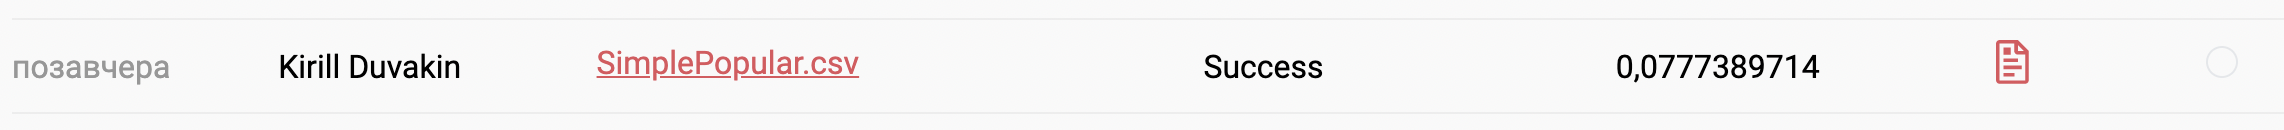

# <span style="color: #034f84">Popular Covered By N Percent</span>

In [19]:
from models import PopularCoveredByNPercent

In [20]:
result_pop_cov = []
for percent in [0.2, 0.4, 0.6, 0.8, 0.9]:
    print(f"\n-------------------- percent = {percent}")
    fold_iterator = cv.split(inters, collect_fold_stats=True)
    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        # split into train and test
        print(f"\n==================== Fold {i_fold + 1}")
        df_train = inters.df.iloc[train_ids]
        df_test = inters.df.iloc[test_ids][Columns.UserItem]
        print(f'Train: {df_train.shape[0]} | Test:{df_test.shape[0]}')

        # construct dataset and fit model
        dataset = Dataset.construct(interactions_df=df_train)
        pop_model = PopularCoveredByNPercent(
            percent=percent,
            max_k=10
        )
        pop_model.fit(dataset)

        # make prediction and calculate metrics
        recs = pd.DataFrame({Columns.User: df_test[Columns.User].unique()})
        recs[Columns.Item] = pop_model.recommend(recs[Columns.User])
        recs = recs.explode(Columns.Item)
        recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1

        fold_metric = compute_metrics(df_train, df_test, recs)
        res = {
            "fold": i_fold + 1,
            "model": f"PopularCovereBy_{percent}",
            "MAP@10": fold_metric.values[0]
        }
        result_pop_cov.append(res)

df_result_pop_cov = pd.DataFrame(result_pop_cov)


-------------------- percent = 0.2

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

-------------------- percent = 0.4

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

-------------------- percent = 0.6

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

-------------------- percent = 0.8

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

-------------------- percent = 0.9

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

=======

In [21]:
df_result_pop_cov

,fold,model,MAP@10
0,1,PopularCovereBy_0.2,0.033705
1,2,PopularCovereBy_0.2,0.028415
2,3,PopularCovereBy_0.2,0.024936
3,1,PopularCovereBy_0.4,0.062710
4,2,PopularCovereBy_0.4,0.056070
5,3,PopularCovereBy_0.4,0.051399
6,1,PopularCovereBy_0.6,0.075705
7,2,PopularCovereBy_0.6,0.068509
8,3,PopularCovereBy_0.6,0.062876
9,1,PopularCovereBy_0.8,0.075705


In [22]:
pivot_result_pop_cov = (
    pd.DataFrame(result_pop_cov)
    .drop(columns='fold')
    .groupby(['model'], sort=False)
    .agg(['mean', 'std'])
)
pivot_result_pop_cov.round(5)

MAP@10         
                        mean      std
model                                
PopularCovereBy_0.2  0.02902  0.00442
PopularCovereBy_0.4  0.05673  0.00568
PopularCovereBy_0.6  0.06903  0.00643
PopularCovereBy_0.8  0.06903  0.00643
PopularCovereBy_0.9  0.06903  0.00643

# <span style="color: #034f84">Popular Covered By N Percent Submission</span>

In [23]:
train = interactions
test = submission

In [24]:
dataset = Dataset.construct(interactions_df=train)
pop_model = PopularCoveredByNPercent(
    percent=0.6,
    max_k=10
)
pop_model.fit(dataset)

recs = pd.DataFrame({Columns.User: test[Columns.User].unique()})
recs[Columns.Item] = pop_model.recommend(recs[Columns.User])
recs = recs.explode(Columns.Item)
recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1

In [25]:
recs = recs.groupby(Columns.User).agg({Columns.Item: list}).reset_index()

In [26]:
recs.head()

,user_id,item_id
0,3,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
1,11,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
2,29,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
3,30,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."
4,33,"[10440, 15297, 9728, 13865, 2657, 4151, 3734, ..."


In [27]:
recs.to_csv('submissions/PopularCoveredByN.csv', index=False)

# <span style="color: #034f84">Leaderboard result</span>

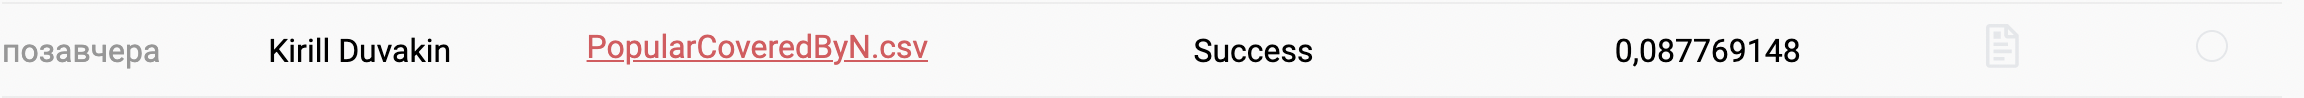

# <span style="color: #034f84">Popular In User Category</span>

In [28]:
from models import PopularInUserCategory

In [29]:
result_pop_cat = []
for cat_f in ['age', 'income']:
    print(f"\n-------------------- cat_feature = {cat_f}")
    fold_iterator = cv.split(inters, collect_fold_stats=True)
    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        # split into train and test
        print(f"\n==================== Fold {i_fold + 1}")
        df_train = inters.df.iloc[train_ids]
        df_test = inters.df.iloc[test_ids][Columns.UserItem]
        print(f'Train: {df_train.shape[0]} | Test:{df_test.shape[0]}')

        # construct dataset and fit model
        df_train = pd.merge(
            df_train, 
            users[[Columns.User, cat_f]],
            on=Columns.User,
            how='left'
        )
        pop_model = PopularInUserCategory(
            cat_feature=cat_f,
            max_k=10
        )
        pop_model.fit(df_train)

        # make prediction and calculate metrics
        recs = pd.DataFrame({Columns.User: df_test[Columns.User].unique()})
        recs = pd.merge(recs, users[[Columns.User, cat_f]], on=Columns.User, how='left')
        recs = pop_model.recommend(recs)
        recs = recs.explode(Columns.Item)
        recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1

        fold_metric = compute_metrics(df_train, df_test, recs)
        res = {
            "fold": i_fold + 1,
            "model": f"PopularInUserCategory_{cat_f}",
            "MAP@10": fold_metric.values[0]
        }
        result_pop_cat.append(res)

df_result_pop_cat = pd.DataFrame(result_pop_cat)


-------------------- cat_feature = age

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228

-------------------- cat_feature = income

==================== Fold 1
Train: 4203885 | Test:264039

==================== Fold 2
Train: 4587708 | Test:276699

==================== Fold 3
Train: 4985269 | Test:297228


In [30]:
df_result_pop_cat

,fold,model,MAP@10
0,1,PopularInUserCategory_age,0.077185
1,2,PopularInUserCategory_age,0.069878
2,3,PopularInUserCategory_age,0.064670
3,1,PopularInUserCategory_income,0.076447
4,2,PopularInUserCategory_income,0.070082
5,3,PopularInUserCategory_income,0.064063


In [31]:
pivot_result_pop_cat = (
    pd.DataFrame(result_pop_cat)
    .drop(columns='fold')
    .groupby(['model'], sort=False)
    .agg(['mean', 'std'])
)
pivot_result_pop_cat.round(5)

MAP@10         
                                 mean      std
model                                         
PopularInUserCategory_age     0.07058  0.00629
PopularInUserCategory_income  0.07020  0.00619

# <span style="color: #034f84">Popular In User Category submission</span>

In [32]:
train = interactions
test = submission
cat_feature = 'age'
df_train = pd.merge(
    train, 
    users[[Columns.User, cat_feature]],
    on=Columns.User,
    how='left'
)
pop_model = PopularInUserCategory(
    cat_feature=cat_feature,
    max_k=10
)
pop_model.fit(df_train)

# make prediction and calculate metrics
recs = pd.DataFrame({Columns.User: test[Columns.User].unique()})
recs = pd.merge(recs, users[[Columns.User, cat_feature]], on=Columns.User, how='left')
recs = pop_model.recommend(recs)
recs = recs.explode(Columns.Item)
recs[Columns.Rank] = recs.groupby(Columns.User).cumcount() + 1

In [33]:
recs = recs.groupby(Columns.User).agg({Columns.Item: list}).reset_index()

In [34]:
recs.head()

,user_id,item_id
0,3,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
1,11,"[10440, 15297, 13865, 9728, 4151, 3734, 4880, ..."
2,29,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
3,30,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
4,33,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."


In [35]:
recs.to_csv('PopularInUserCategory.csv', index=False)

# <span style="color: #034f84">Leaderboard result</span>

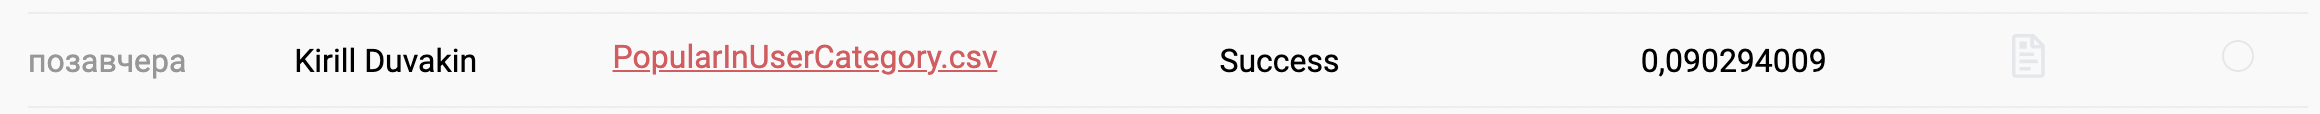